In [1]:
import sys
sys.path.append('../src/')
from corpus import Corpus
from models import GTM
from simulations import generate_documents
from sklearn.feature_extraction.text import CountVectorizer

df_theta, df, topic_words, true_lambda, true_label_coeffs = generate_documents(
    num_docs=10000,
    num_topics=2,
    vocab_size=500,
    min_words=1000,
    max_words=1000,
    num_covs=2,
    num_languages=1,
    doc_topic_prior="logistic_normal",
    label_type="regression",
    random_seed=42
)

In [2]:
train = df.sample(frac=0.8,random_state=42)
test = df.drop(train.index).reset_index(drop=True)
train = train.reset_index(drop=True)

# ---- 1. Fit vectorizer on training set ----
vectorizer = CountVectorizer()  
vectorizer.fit(train["doc_clean_0"])

# ---- 2. Define modalities using this vectorizer ----
modalities = {
    "text": {
        "column": "doc_clean_0",
        "views": {
            "bow": {
                "type": "bow",
                "vectorizer": vectorizer
            }
        }
    }
}

# ---- 3. Create GTMCorpus datasets ----
train_dataset = Corpus(
    train,
    modalities=modalities,
    labels="~label-1",
    prevalence="~cov_1 + cov_2"
)

test_dataset = Corpus(
    test,
    modalities=modalities,  
    labels="~label-1",
    prevalence="~cov_1 + cov_2"
)

In [3]:
# Train the model

encoder_args = {
    "text_bow": {
        "hidden_dims": [512],
        "activation": "relu",
        "bias": True,
        "dropout": 0.0
    }
}

decoder_args = {
    "text_bow": {
        "hidden_dims": [],
        "activation": "relu",
        "bias": True,
        "dropout": 0.0
    }
}

predictor_args = {
    "text_bow": {
        "hidden_dims": [],
        "activation": "relu",
        "bias": False,
        "dropout": 0.0
    }
}

tm = GTM(
    train_dataset, 
    test_dataset,
    ae_type="vae",
    vi_type="iaf",
    fixed_prior=False,
    encoder_args=encoder_args,
    decoder_args=decoder_args,
    predictor_args=predictor_args,
    n_topics=2,
    batch_size=64,
    doc_topic_prior='logistic_normal',
    predictor_type='regressor', 
    w_pred_loss=1,
    w_prior=0.01,
    patience=10,
    print_every_n_batches=10000,
    print_every_n_epochs=1,
    kl_annealing_start=-1,
    kl_annealing_end=-1,
    num_epochs=100
)


Epoch   1	Mean Training Loss:6.2527403


Epoch   1	Mean Validation Loss:6.0519088


Epoch   2	Mean Training Loss:5.8984721


Epoch   2	Mean Validation Loss:5.7556076


Epoch   3	Mean Training Loss:5.6248565


Epoch   3	Mean Validation Loss:5.5138667


Epoch   4	Mean Training Loss:5.4148739


Epoch   4	Mean Validation Loss:5.3333649


Epoch   5	Mean Training Loss:5.2586778


Epoch   5	Mean Validation Loss:5.1978801


Epoch   6	Mean Training Loss:5.1416384


Epoch   6	Mean Validation Loss:5.0966718


Epoch   7	Mean Training Loss:5.0537802


Epoch   7	Mean Validation Loss:5.0194889


Epoch   8	Mean Training Loss:4.9864642


Epoch   8	Mean Validation Loss:4.9619248


Epoch   9	Mean Training Loss:4.9360209


Epoch   9	Mean Validation Loss:4.9174522


Epoch  10	Mean Training Loss:4.8967507


Epoch  10	Mean Validation Loss:4.8835690


Epoch  11	Mean Training Loss:4.8666484


Epoch  11	Mean Validation Loss:4.8564528


Epoch  12	Mean Training Loss:4.8429195


Epoch  12	Mean Validation Loss:4.8

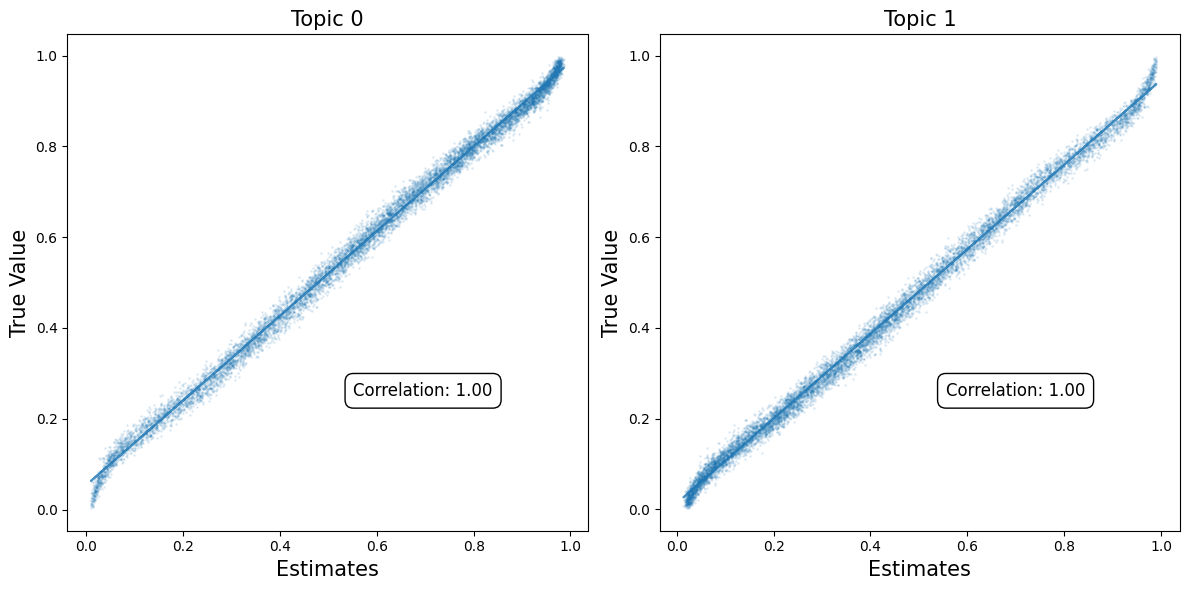

In [4]:
import matplotlib.pyplot as plt
import numpy as np

full_dataset = Corpus(
    df,
    modalities=modalities,
    labels="~label-1",
    prevalence="~cov_1 + cov_2"
)

estimated_doc_topics = tm.get_doc_topic_distribution(full_dataset, num_samples=30)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for i in range(2):  
    x = estimated_doc_topics[:, i]  
    y = df_theta['Topic{}'.format(i)]
    
    axs[i].scatter(x, y, s=1, alpha=0.1)
    
    coefficients = np.polyfit(x, y, 1)
    fit = np.poly1d(coefficients)
    axs[i].plot(x, fit(x), alpha=0.8)
    
    axs[i].set_xlabel('Estimates', fontsize=15)
    axs[i].set_ylabel('True Value', fontsize=15)
    axs[i].set_title(f'Topic {i}', fontsize=15)

    corr_coeff = np.corrcoef(x, y)[0, 1]
    axs[i].annotate(f'Correlation: {corr_coeff:.2f}', xy=(0.55, 0.3), xycoords='axes fraction',
                    fontsize=12, verticalalignment='top', horizontalalignment='left',
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()

In [5]:
print("True label_coeffs:\n", true_label_coeffs)

print('Estimated weights:')
print(tm.predictor.neural_net["pred_0"].weight.detach().cpu())

True label_coeffs:
 [-0.84190469  0.53676052]
Estimated weights:
tensor([[-0.7646,  0.5137]])


In [6]:
tm.get_predictions(full_dataset, to_numpy=False, num_samples=30)[0:10]

tensor([[-0.2278],
        [-0.5371],
        [-0.0274],
        [-0.0090],
        [-0.1778],
        [-0.4335],
        [ 0.0674],
        [-0.3608],
        [ 0.4285],
        [-0.0891]], device='cuda:0')

In [7]:
print(df['label'].iloc[0:10])

0   -0.114116
1   -0.517804
2   -0.009815
3   -0.054542
4   -0.159797
5   -0.434752
6    0.042264
7   -0.387451
8    0.412938
9    0.045037
Name: label, dtype: float64


In [8]:
import torch 

def compare_prior_parameters_with_identifiability(tm, simulation_results, constraint_dim=-1):
    """
    Compare learned and true prior parameters with identifiability constraint.
    
    Args:
        tm: trained GTM model
        simulation_results: tuple returned from generate_documents()
        constraint_dim: which dimension to set to zero (default: last dimension)
    
    Returns:
        comparison_results: dictionary with differences and constrained parameters
    """
    # Extract true parameters from simulation results
    df_topic_dist, df, topic_word_matrices, true_lambda, true_label_coeffs = simulation_results
    
    if true_lambda is None:
        print("No covariates in simulation - cannot compare covariate effects")
        return None
    
    # Get learned parameters from the trained model
    if tm.latent_factor_prior == "logistic_normal":
        if hasattr(tm.prior, 'prevalence_covariate_size') and tm.prior.prevalence_covariate_size > 0:
            # Get learned lambda (covariate effects on mean)
            if hasattr(tm.prior, 'mean_net'):
                # Extract weights and bias from the linear layer
                learned_lambda = tm.prior.mean_net.weight.detach().cpu().numpy()  # Shape: (K, num_covs+1)
                learned_lambda = learned_lambda.T  # Transpose to match simulation format: (num_covs+1, K)
            else:
                print("No covariate effects in learned prior")
                return None
                
            # Get learned sigma (covariance matrix)
            learned_sigma = tm.prior.sigma.detach().cpu().numpy()  # Shape: (K, K)
            
        else:
            print("No covariates in learned prior")
            return None
            
    elif tm.latent_factor_prior == "dirichlet":
        if hasattr(tm.prior, 'prevalence_covariate_size') and tm.prior.prevalence_covariate_size > 0:
            # For Dirichlet, we compare concentration parameters
            # This is more complex as Dirichlet doesn't have lambda/sigma structure
            print("Dirichlet prior comparison not implemented yet")
            return None
        else:
            print("No covariates in learned Dirichlet prior")
            return None
    else:
        raise ValueError(f"Unsupported prior type: {tm.latent_factor_prior}")
    
    # Convert true parameters to tensors
    true_lambda = torch.tensor(true_lambda, dtype=torch.float32)
    true_sigma = torch.tensor(np.eye(tm.n_topics) if len(simulation_results) < 4 else np.eye(tm.n_topics), dtype=torch.float32)
    
    # Apply identifiability constraint: set specified dimension to zero
    learned_lambda_constrained = torch.tensor(learned_lambda.copy(), dtype=torch.float32)
    learned_lambda_constrained[:, constraint_dim] = 0.0
    
    true_lambda_constrained = true_lambda.clone()
    true_lambda_constrained[:, constraint_dim] = 0.0
    
    # For covariance, we typically don't constrain it directly in this context
    learned_sigma_constrained = torch.tensor(learned_sigma, dtype=torch.float32)
    true_sigma_constrained = true_sigma.clone()
    
    # Compare constrained parameters
    lambda_diff = torch.norm(learned_lambda_constrained - true_lambda_constrained)
    sigma_diff = torch.norm(learned_sigma_constrained - true_sigma_constrained, 'fro')  # Frobenius norm
    
    # Element-wise comparison for lambda
    lambda_elementwise_diff = torch.abs(learned_lambda_constrained - true_lambda_constrained)
    
    print("="*60)
    print("PRIOR PARAMETER COMPARISON (K dimensions)")
    print("="*60)
    print("TRUE PARAMETERS:")
    print(f"True Lambda (shape {true_lambda_constrained.shape}):")
    for i, row in enumerate(true_lambda_constrained):
        print(f"  Covariate {i}: {row.numpy()}")
    print(f"True Sigma diagonal: {torch.diag(true_sigma_constrained).numpy()}")
    print()
    
    print("LEARNED PARAMETERS:")
    print(f"Learned Lambda (shape {learned_lambda_constrained.shape}):")
    for i, row in enumerate(learned_lambda_constrained):
        print(f"  Covariate {i}: {row.numpy()}")
    print(f"Learned Sigma diagonal: {torch.diag(learned_sigma_constrained).numpy()}")
    print()
    
    print("DIFFERENCES:")
    print(f"Lambda L2 difference:         {lambda_diff:.6f}")
    print(f"Lambda element-wise diff:")
    for i, row in enumerate(lambda_elementwise_diff):
        print(f"  Covariate {i}: {row.numpy()}")
    print(f"Sigma Frobenius difference:   {sigma_diff:.6f}")
    print()
    
    # Per-topic comparison
    print("PER-TOPIC LAMBDA DIFFERENCES:")
    for topic in range(tm.n_topics):
        if topic != constraint_dim:  # Skip constrained dimension
            topic_diff = torch.norm(learned_lambda_constrained[:, topic] - true_lambda_constrained[:, topic])
            print(f"Topic {topic}: L2 diff = {topic_diff:.6f}")
    
    return {
        'learned_lambda_constrained': learned_lambda_constrained.numpy(),
        'true_lambda_constrained': true_lambda_constrained.numpy(),
        'learned_sigma_constrained': learned_sigma_constrained.numpy(),
        'true_sigma_constrained': true_sigma_constrained.numpy(),
        'lambda_l2_diff': lambda_diff.item(),
        'sigma_frobenius_diff': sigma_diff.item(),
        'lambda_elementwise_diff': lambda_elementwise_diff.numpy(),
        'constraint_dim': constraint_dim,
        'per_topic_lambda_diff': {
            topic: torch.norm(learned_lambda_constrained[:, topic] - true_lambda_constrained[:, topic]).item()
            for topic in range(tm.n_topics) if topic != constraint_dim
        }
    }

def extract_simulation_parameters(simulation_results):
    """
    Extract the true parameters from simulation results for easy access.
    
    Args:
        simulation_results: tuple returned from generate_documents()
    
    Returns:
        Dictionary with extracted parameters
    """
    df_topic_dist, df, topic_word_matrices, true_lambda, true_label_coeffs = simulation_results
    
    return {
        'true_doc_topic_distribution': df_topic_dist.values,
        'true_lambda': true_lambda,
        'true_label_coeffs': true_label_coeffs,
        'topic_word_matrices': topic_word_matrices,
        'num_topics': df_topic_dist.shape[1],
        'num_docs': df_topic_dist.shape[0],
        'covariate_names': [col for col in df.columns if col.startswith('cov_')]
    }

simulation_results = (df_theta, df, topic_words, true_lambda, true_label_coeffs)

results = compare_prior_parameters_with_identifiability(
    tm=tm,
    simulation_results=simulation_results,
    constraint_dim=-1  # Set last dimension to zero for identifiability
)

# Access specific results
if results:
    print(f"Overall parameter recovery error: {results['lambda_l2_diff']:.6f}")
    print("Per-topic recovery errors:", results['per_topic_lambda_diff'])
    
    # Extract specific learned vs true parameters
    learned_lambda = results['learned_lambda_constrained']
    true_lambda = results['true_lambda_constrained']
    
    print("\nCovariate effect comparison:")
    for cov_idx in range(learned_lambda.shape[0]):
        print(f"Covariate {cov_idx}:")
        print(f"  True:    {true_lambda[cov_idx]}")
        print(f"  Learned: {learned_lambda[cov_idx]}")
        print(f"  Diff:    {np.abs(true_lambda[cov_idx] - learned_lambda[cov_idx])}")

PRIOR PARAMETER COMPARISON (K dimensions)
TRUE PARAMETERS:
True Lambda (shape torch.Size([3, 2])):
  Covariate 0: [-0.7439309  0.       ]
  Covariate 1: [0.19440946 0.        ]
  Covariate 2: [0.55631715 0.        ]
True Sigma diagonal: [1. 1.]

LEARNED PARAMETERS:
Learned Lambda (shape torch.Size([3, 2])):
  Covariate 0: [0.04483688 0.        ]
  Covariate 1: [0.07321498 0.        ]
  Covariate 2: [0.05612048 0.        ]
Learned Sigma diagonal: [1.7819959 1.7756616]

DIFFERENCES:
Lambda L2 difference:         0.941828
Lambda element-wise diff:
  Covariate 0: [0.78876776 0.        ]
  Covariate 1: [0.12119448 0.        ]
  Covariate 2: [0.5001967 0.       ]
Sigma Frobenius difference:   1.105864

PER-TOPIC LAMBDA DIFFERENCES:
Topic 0: L2 diff = 0.941828
Topic 1: L2 diff = 0.000000
Overall parameter recovery error: 0.941828
Per-topic recovery errors: {0: 0.9418277144432068, 1: 0.0}

Covariate effect comparison:
Covariate 0:
  True:    [-0.7439309  0.       ]
  Learned: [0.04483688 0.   

True lambda shape: (3, 2)
Learned lambda shape: (3, 2)
Learned sigma shape: (2, 2)
True number of covariates (including intercept): 3
Learned number of covariates (including intercept): 3
True covariate vector shape: (3,)
Learned covariate vector shape: (3,)
True covariate vector: [1. 1. 0.]
Learned covariate vector: [1. 1. 0.]
True mean: [-0.5495214  -1.14952971]
Learned mean: [ 0.11805185 -0.0877531 ]
True mean constrained: [-0.5495214  0.       ]
Learned mean constrained: [0.11805185 0.        ]
DISTRIBUTION COMPARISON
Covariate configuration: {'cov_0': 1.0, 'cov_1': 0.0}
Number of samples: 2000

MEANS (after identifiability constraint):
True mean:    [-0.5495214  0.       ]
Learned mean: [0.11805185 0.        ]
Mean difference (L2): 0.667573

COVARIANCES:
True covariance diagonal: [1. 1.]
Learned covariance diagonal: [1.7819959 1.7756616]
Covariance difference (Frobenius): 1.105864
STATISTICAL COMPARISON

Topic 0:
  Mean:     True=-0.5383, Learned=0.1663, Diff=0.7046
  Std:      Tr

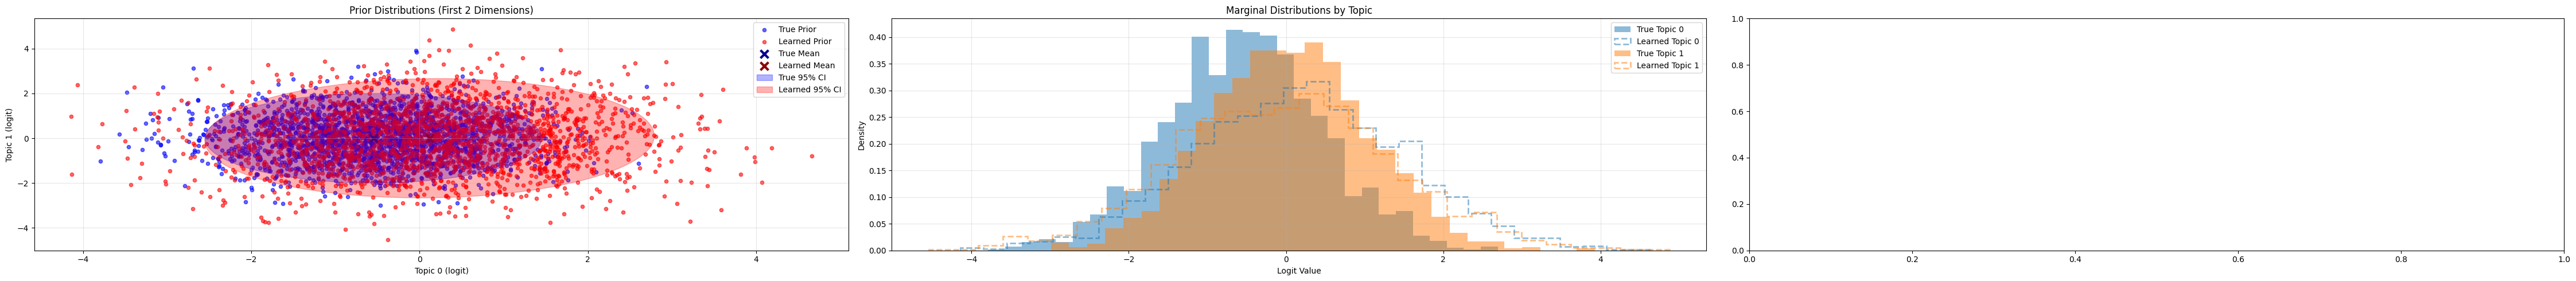

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from scipy.stats import multivariate_normal
from sklearn.decomposition import PCA

def plot_prior_distributions(tm, simulation_results, constraint_dim=-1, 
                           covariate_config=None, n_samples=1000, 
                           plot_types=['scatter_2d', 'marginals', 'pca'], 
                           figsize=(15, 5)):
    """
    Plot comparison between true and learned prior distributions.
    
    Args:
        tm: trained GTM model
        simulation_results: tuple returned from generate_documents()
        constraint_dim: which dimension to set to zero for identifiability
        covariate_config: dict with covariate values, e.g., {'cov_0': 1.0, 'cov_1': 0.5}
                         If None, uses zero covariates
        n_samples: number of samples to draw from each distribution
        plot_types: list of plot types to generate
        figsize: figure size for each subplot
    """
    # Extract parameters
    df_topic_dist, df, topic_word_matrices, true_lambda, true_label_coeffs = simulation_results
    
    if true_lambda is None:
        print("No covariates in simulation - cannot compare distributions")
        return None
    
    # Debug: Print shapes
    print(f"True lambda shape: {true_lambda.shape}")
    
    # Get learned parameters
    if hasattr(tm.prior, 'mean_net'):
        learned_lambda_raw = tm.prior.mean_net.weight.detach().cpu().numpy()  # Shape: (K, num_covs+1)
        learned_lambda = learned_lambda_raw.T  # Shape: (num_covs+1, K)
        print(f"Learned lambda shape: {learned_lambda.shape}")
    else:
        print("No learned lambda found")
        return None
    
    learned_sigma = tm.prior.sigma.detach().cpu().numpy()
    print(f"Learned sigma shape: {learned_sigma.shape}")
    
    # Determine the number of covariates from the shapes
    true_n_covs = true_lambda.shape[0]  # includes intercept
    learned_n_covs = learned_lambda.shape[0]  # includes intercept
    
    print(f"True number of covariates (including intercept): {true_n_covs}")
    print(f"Learned number of covariates (including intercept): {learned_n_covs}")
    
    # Set default covariate configuration based on the true lambda shape
    if covariate_config is None:
        # Create config for all non-intercept covariates
        covariate_config = {f'cov_{i}': 0.0 for i in range(true_n_covs - 1)}
    
    # Create covariate vector for true parameters
    true_cov_vector = np.array([1.0] + [covariate_config.get(f'cov_{i}', 0.0) 
                                       for i in range(true_n_covs - 1)])
    
    # Create covariate vector for learned parameters (might have different size)
    learned_cov_vector = np.array([1.0] + [covariate_config.get(f'cov_{i}', 0.0) 
                                          for i in range(learned_n_covs - 1)])
    
    print(f"True covariate vector shape: {true_cov_vector.shape}")
    print(f"Learned covariate vector shape: {learned_cov_vector.shape}")
    print(f"True covariate vector: {true_cov_vector}")
    print(f"Learned covariate vector: {learned_cov_vector}")
    
    # Check if dimensions match
    if true_cov_vector.shape[0] != true_lambda.shape[0]:
        print(f"Warning: True covariate vector size {true_cov_vector.shape[0]} doesn't match true lambda rows {true_lambda.shape[0]}")
        # Pad or truncate as needed
        if true_cov_vector.shape[0] < true_lambda.shape[0]:
            true_cov_vector = np.pad(true_cov_vector, (0, true_lambda.shape[0] - true_cov_vector.shape[0]))
        else:
            true_cov_vector = true_cov_vector[:true_lambda.shape[0]]
    
    if learned_cov_vector.shape[0] != learned_lambda.shape[0]:
        print(f"Warning: Learned covariate vector size {learned_cov_vector.shape[0]} doesn't match learned lambda rows {learned_lambda.shape[0]}")
        # Pad or truncate as needed
        if learned_cov_vector.shape[0] < learned_lambda.shape[0]:
            learned_cov_vector = np.pad(learned_cov_vector, (0, learned_lambda.shape[0] - learned_cov_vector.shape[0]))
        else:
            learned_cov_vector = learned_cov_vector[:learned_lambda.shape[0]]
    
    # Get true distribution parameters
    true_mean = true_lambda.T @ true_cov_vector  # Shape: (K,)
    true_cov = np.eye(len(true_mean))  # Assuming identity covariance for simulation
    
    # Apply identifiability constraint
    true_mean_constrained = true_mean.copy()
    true_mean_constrained[constraint_dim] = 0.0
    
    # Get learned distribution parameters
    learned_mean = learned_lambda.T @ learned_cov_vector
    learned_cov = learned_sigma
    
    # Apply identifiability constraint
    learned_mean_constrained = learned_mean.copy()
    learned_mean_constrained[constraint_dim] = 0.0
    
    print(f"True mean: {true_mean}")
    print(f"Learned mean: {learned_mean}")
    print(f"True mean constrained: {true_mean_constrained}")
    print(f"Learned mean constrained: {learned_mean_constrained}")
    
    # Sample from both distributions
    true_samples = np.random.multivariate_normal(true_mean_constrained, true_cov, n_samples)
    learned_samples = np.random.multivariate_normal(learned_mean_constrained, learned_cov, n_samples)
    
    # Create plots
    n_plots = len(plot_types)
    fig, axes = plt.subplots(1, n_plots, figsize=(figsize[0] * n_plots, figsize[1]))
    if n_plots == 1:
        axes = [axes]
    
    plot_idx = 0
    
    # 2D scatter plot (first two dimensions)
    if 'scatter_2d' in plot_types and tm.n_topics >= 2:
        ax = axes[plot_idx]
        
        # Plot samples
        ax.scatter(true_samples[:, 0], true_samples[:, 1], 
                  alpha=0.6, s=20, color='blue', label='True Prior')
        ax.scatter(learned_samples[:, 0], learned_samples[:, 1], 
                  alpha=0.6, s=20, color='red', label='Learned Prior')
        
        # Plot means
        ax.scatter(true_mean_constrained[0], true_mean_constrained[1], 
                  s=100, color='darkblue', marker='x', linewidth=3, label='True Mean')
        ax.scatter(learned_mean_constrained[0], learned_mean_constrained[1], 
                  s=100, color='darkred', marker='x', linewidth=3, label='Learned Mean')
        
        # Add confidence ellipses
        plot_confidence_ellipse(true_mean_constrained[:2], true_cov[:2, :2], ax, 
                               color='blue', alpha=0.3, label='True 95% CI')
        plot_confidence_ellipse(learned_mean_constrained[:2], learned_cov[:2, :2], ax, 
                               color='red', alpha=0.3, label='Learned 95% CI')
        
        ax.set_xlabel('Topic 0 (logit)')
        ax.set_ylabel('Topic 1 (logit)')
        ax.set_title('Prior Distributions (First 2 Dimensions)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plot_idx += 1
    
    # Marginal distributions
    if 'marginals' in plot_types:
        ax = axes[plot_idx]
        
        # Plot marginal distributions for each topic
        n_topics_to_plot = min(4, tm.n_topics)  # Limit to 4 topics for readability
        
        for topic in range(n_topics_to_plot):
            if topic == constraint_dim:
                continue  # Skip constrained dimension
                
            # True marginal
            true_marginal = true_samples[:, topic]
            ax.hist(true_marginal, bins=30, alpha=0.5, density=True, 
                   label=f'True Topic {topic}', color=f'C{topic}')
            
            # Learned marginal
            learned_marginal = learned_samples[:, topic]
            ax.hist(learned_marginal, bins=30, alpha=0.5, density=True, 
                   linestyle='--', histtype='step', linewidth=2,
                   label=f'Learned Topic {topic}', color=f'C{topic}')
        
        ax.set_xlabel('Logit Value')
        ax.set_ylabel('Density')
        ax.set_title('Marginal Distributions by Topic')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plot_idx += 1
    
    # PCA projection
    if 'pca' in plot_types and tm.n_topics > 2:
        ax = axes[plot_idx]
        
        # Combine samples for PCA fitting
        all_samples = np.vstack([true_samples, learned_samples])
        pca = PCA(n_components=2)
        all_samples_pca = pca.fit_transform(all_samples)
        
        # Split back
        true_samples_pca = all_samples_pca[:n_samples]
        learned_samples_pca = all_samples_pca[n_samples:]
        
        # Plot PCA projections
        ax.scatter(true_samples_pca[:, 0], true_samples_pca[:, 1], 
                  alpha=0.6, s=20, color='blue', label='True Prior')
        ax.scatter(learned_samples_pca[:, 0], learned_samples_pca[:, 1], 
                  alpha=0.6, s=20, color='red', label='Learned Prior')
        
        # Transform means
        true_mean_pca = pca.transform(true_mean_constrained.reshape(1, -1))[0]
        learned_mean_pca = pca.transform(learned_mean_constrained.reshape(1, -1))[0]
        
        ax.scatter(true_mean_pca[0], true_mean_pca[1], 
                  s=100, color='darkblue', marker='x', linewidth=3, label='True Mean')
        ax.scatter(learned_mean_pca[0], learned_mean_pca[1], 
                  s=100, color='darkred', marker='x', linewidth=3, label='Learned Mean')
        
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
        ax.set_title('PCA Projection of Prior Distributions')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plot_idx += 1
    
    plt.tight_layout()
    
    # Print distribution statistics
    print("="*60)
    print("DISTRIBUTION COMPARISON")
    print("="*60)
    print(f"Covariate configuration: {covariate_config}")
    print(f"Number of samples: {n_samples}")
    print()
    
    print("MEANS (after identifiability constraint):")
    print(f"True mean:    {true_mean_constrained}")
    print(f"Learned mean: {learned_mean_constrained}")
    print(f"Mean difference (L2): {np.linalg.norm(true_mean_constrained - learned_mean_constrained):.6f}")
    print()
    
    print("COVARIANCES:")
    print("True covariance diagonal:", np.diag(true_cov))
    print("Learned covariance diagonal:", np.diag(learned_cov))
    print(f"Covariance difference (Frobenius): {np.linalg.norm(true_cov - learned_cov, 'fro'):.6f}")
    
    return {
        'true_samples': true_samples,
        'learned_samples': learned_samples,
        'true_mean': true_mean_constrained,
        'learned_mean': learned_mean_constrained,
        'true_cov': true_cov,
        'learned_cov': learned_cov,
        'covariate_config': covariate_config
    }

def plot_confidence_ellipse(mean, cov, ax, n_std=2.0, **kwargs):
    """
    Plot confidence ellipse for 2D distribution.
    """
    from matplotlib.patches import Ellipse
    
    eigenvals, eigenvecs = np.linalg.eigh(cov)
    order = eigenvals.argsort()[::-1]
    eigenvals, eigenvecs = eigenvals[order], eigenvecs[:, order]
    
    angle = np.degrees(np.arctan2(*eigenvecs[:, 0][::-1]))
    width, height = 2 * n_std * np.sqrt(eigenvals)
    
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, **kwargs)
    ax.add_patch(ellipse)

def compare_distribution_statistics(true_samples, learned_samples, topic_names=None):
    """
    Compare statistical properties of the two distributions.
    """
    if topic_names is None:
        topic_names = [f'Topic {i}' for i in range(true_samples.shape[1])]
    
    print("="*60)
    print("STATISTICAL COMPARISON")
    print("="*60)
    
    for i, topic in enumerate(topic_names):
        print(f"\n{topic}:")
        true_vals = true_samples[:, i]
        learned_vals = learned_samples[:, i]
        
        print(f"  Mean:     True={true_vals.mean():.4f}, Learned={learned_vals.mean():.4f}, Diff={abs(true_vals.mean() - learned_vals.mean()):.4f}")
        print(f"  Std:      True={true_vals.std():.4f}, Learned={learned_vals.std():.4f}, Diff={abs(true_vals.std() - learned_vals.std()):.4f}")
        print(f"  Min:      True={true_vals.min():.4f}, Learned={learned_vals.min():.4f}")
        print(f"  Max:      True={true_vals.max():.4f}, Learned={learned_vals.max():.4f}")
        
        # Kolmogorov-Smirnov test
        from scipy.stats import ks_2samp
        ks_stat, ks_pval = ks_2samp(true_vals, learned_vals)
        print(f"  KS test:  stat={ks_stat:.4f}, p-value={ks_pval:.4f}")

# Example usage with debugging
plot_results = plot_prior_distributions(
    tm=tm,
    simulation_results=simulation_results,
    constraint_dim=-1,
    covariate_config={'cov_0': 1.0, 'cov_1': 0.0},  # Example covariate values
    n_samples=2000,
    plot_types=['scatter_2d', 'marginals', 'pca']
)

# Additional statistical comparison
if plot_results:
    compare_distribution_statistics(
        plot_results['true_samples'], 
        plot_results['learned_samples']
    )
    
plt.show()